CANADA MISSION NEWS ARTICLES

https://www.international.gc.ca/world-monde/international_relations-relations_internationales/un-onu/statements-declarations/index.aspx?lang=eng

STEP 1 - SCRAPE DATA FROM WEBSITE

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

In [16]:
org_news_div = soup.find("div", class_="org-news")
if org_news_div:
    feed_sections = org_news_div.find_all("section", class_="wb-feeds")
    print(f"Found {len(feed_sections)} sections inside org-news")
    for sec in feed_sections:
        print(sec.get('id'))
else:
    print("No org-news div found")

Found 2 sections inside org-news
None
None


In [24]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import time
from dateutil import parser




URL = "https://www.international.gc.ca/world-monde/international_relations-relations_internationales/un-onu/statements-declarations/index.aspx?lang=eng"
CUTOFF_DATE = datetime(2018, 1, 1)


driver = webdriver.Chrome()
driver.get(URL)

# ⏱️ Wait for the JavaScript to finish loading content
time.sleep(10)

soup = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()

# ✅ Parse content from .org-news div
org_news = soup.find("div", class_="org-news")
sections = org_news.find_all("section") if org_news else []

print(f"🔍 Found {len(sections)} <section> blocks in .org-news")

articles = []
total_li_count = 0

for i, section in enumerate(sections, 1):
    li_tags = section.find_all("li")
    print(f"➡️ Scraping Section #{i} — Found {len(li_tags)} <li> tags")
    total_li_count += len(li_tags)

    for li in li_tags:
        a_tag = li.find("a", href=True)
        time_tag = li.find("time")

        if not a_tag or not time_tag:
            continue

        title = a_tag.get_text(strip=True)
        href = a_tag["href"].strip()
        url = href if href.startswith("http") else "https://www.international.gc.ca" + href
        date_str = time_tag.get_text(strip=True)

        try:
            date = parser.parse(date_str)
        except Exception:
            print(f"⚠️ Skipping due to unrecognized date: '{date_str}'")
            continue

        if date >= CUTOFF_DATE:
            articles.append({
                "title": title,
                "url": url,
                "date": date.strftime("%Y-%m-%d")
            })

df = pd.DataFrame(articles)
print(f"\n🧾 Total <li> tags processed: {total_li_count}")
print(f"✅ Extracted {len(df)} articles after {CUTOFF_DATE.strftime('%Y-%m-%d')}")
print(df.head())


🔍 Found 2 <section> blocks in .org-news
➡️ Scraping Section #1 — Found 22 <li> tags
➡️ Scraping Section #2 — Found 183 <li> tags

🧾 Total <li> tags processed: 205
✅ Extracted 152 articles after 2018-01-01
                                               title  \
0  Statement by Canada, Australia and New Zealand...   
1  Statement by the Group of Friends of Children ...   
2  Security Council open debate on “Poverty, unde...   
3  Statement of the Co-Chairs of the “United Nati...   
4  Explanation of Vote – Yes – Protection of civi...   

                                                 url        date  
0  https://www.international.gc.ca/world-monde/in...  2025-06-25  
1  https://www.international.gc.ca/world-monde/in...  2025-06-25  
2  https://www.international.gc.ca/world-monde/in...  2025-06-19  
3  https://www.international.gc.ca/world-monde/in...  2025-06-17  
4  https://www.international.gc.ca/world-monde/in...  2025-06-12  


In [25]:
def extract_clean_paragraphs(paragraphs):
    cleaned = []
    for p in paragraphs:
        # Skip if <p> only contains one <strong> or <em>
        children = list(p.children)
        if len(children) == 1 and (p.find("strong") or p.find("em")):
            continue
        text = p.get_text(strip=True)
        if text and len(text) > 30:  # Filter out short/boilerplate
            cleaned.append(text)
    return "\n\n".join(cleaned)

def extract_article_content(url):
    try:
        res = requests.get(url, timeout=10)
        soup = BeautifulSoup(res.content, "html.parser")
        main = soup.find("main")
        if not main:
            return ""
        paragraphs = main.find_all("p")
        return extract_clean_paragraphs(paragraphs)
    except Exception as e:
        print(f"❌ Failed to scrape {url}: {e}")
        return ""

In [ ]:
# Add new "content" column to the existing DataFrame
df["text"] = df["url"].apply(extract_article_content)

excel_path = "canada_mission_statements.xlsx"
sheet_name = 'raw'

df.to_excel(excel_path, sheet_name=sheet_name, index=False)
print(f"📄 Articles saved to {excel_path}")

STEP 2 - DATA ANALYSIS

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import _stop_words
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import re

# Custom stopwords
custom_stopwords = set([
    "canada", "government", "united", "nations", "international", "world",
    "statement", "statements", "mission", "declaration", "relations",
    "un", "onu", "foreign", "policy", "minister", "ministry", 'security',
    'council', 'states', 'support', 'group', 'people', 'including', 'efforts',
    'continue', 'charter', 'member', 'resolution', 'need', 'ensure', 'president',
    'global', 'countries', 'today', 'challenges', 'know', 'action', 'make',
    'canadas'
])

texts = df['text']

# Combine the default English stopwords with custom list:
english_stopwords = _stop_words.ENGLISH_STOP_WORDS  # set of default english stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords))

vectorizer = CountVectorizer(
    max_df=0.85, 
    min_df=5, 
    stop_words=all_stopwords
)

Theme Identification via Natural Language Processing (NLP)

In [66]:
# Topic Identification without bigrams
dtm = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out(),3)

Topic 0:
['weapons', 'nuclear', 'disarmament']
Topic 1:
['women', 'gender', 'violence']
Topic 2:
['women', 'peace', 'peacekeeping']
Topic 3:
['ukraine', 'russia', 'war']
Topic 4:
['children', 'conflict', 'humanitarian']


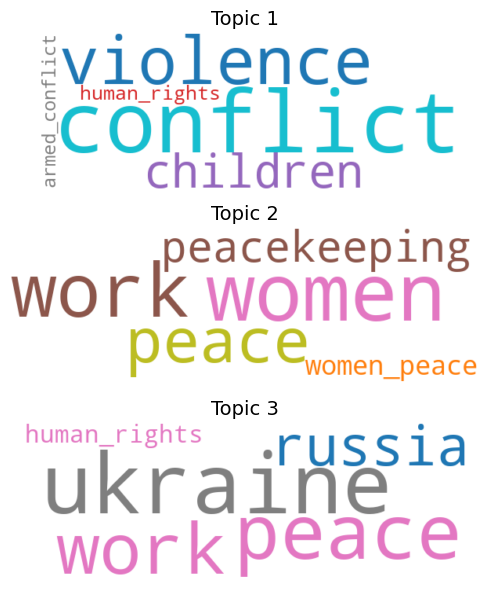

In [67]:
# Topic identification with bigrams
# Text preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in all_stopwords and len(token) > 2]
    return tokens

# Tokenize texts
tokenized_texts = [preprocess(doc) for doc in texts]

# Build bigrams
bigram_model = Phrases(tokenized_texts, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_model)
texts_with_bigrams = [bigram_phraser[doc] for doc in tokenized_texts]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts_with_bigrams)
dictionary.filter_extremes(no_below=5, no_above=0.75)
corpus = [dictionary.doc2bow(text) for text in texts_with_bigrams]

# Train LDA model with 3 topics
num_topics = 3
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Define figure size in inches for a roughly square layout
fig_width = 6
fig_height = 6

# Each word cloud will have height = fig_height / num_topics
wc_width = int(fig_width * 100)   # 100 dpi
wc_height = int((fig_height / num_topics) * 100)

plt.figure(figsize=(fig_width, fig_height))

for topic_id in range(num_topics):
    plt.subplot(num_topics, 1, topic_id + 1)
    words_probs = dict(lda_model.show_topic(topic_id, topn=5))
    wc = WordCloud(
        width=wc_width,
        height=wc_height,
        background_color='white',
        colormap='tab10',
        prefer_horizontal=0.9,
        min_font_size=15,
    ).generate_from_frequencies(words_probs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id + 1}", fontsize=14)

plt.tight_layout()
plt.show()

In [68]:
# Export Topics Words and Weights to Excel for PowerBI
topic_words = []
num_words = 5  # Adjust based on your needs

for topic_id in range(num_topics):
    words_probs = lda_model.show_topic(topic_id, topn=num_words)
    for word, prob in words_probs:
        topic_words.append({"Topic": topic_id + 1, "Word": word, "Probability": prob})

# Convert to DataFrame
wc = pd.DataFrame(topic_words)

sheet_name = "Topic_WordCloud"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    wc.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to Topic_WordCloud in canada_mission_statements.xlsx


Identifying Themes via Keyword Frequency

In [69]:
X = vectorizer.fit_transform(texts)

# Convert to readable DataFrame
X_array = X.toarray()
vocab = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_array, columns=vocab)

# View output
print("Bag of Words Matrix:\n", bow_df.head())

Bag of Words Matrix:
    000  10  1325  15  16  18  19  1945  20  2015  ...  year  years  yemen  \
0    0   0     0   0   0   0   0     0   0     0  ...     0      0      0   
1    0   0     0   0   0   0   0     0   1     0  ...     1      1      0   
2    0   0     0   0   0   0   0     0   0     0  ...     1      0      0   
3    0   0     0   0   0   0   0     0   0     0  ...     0      0      0   
4    0   0     0   0   0   0   0     0   0     0  ...     0      0      0   

   yes  yesterday  york  young  youth  zambia  zealand  
0    0          0     0      0      0       0        1  
1    0          0     0      0      0       0        1  
2    0          0     0      0      1       0        0  
3    0          0     0      0      0       0        0  
4    0          0     0      0      0       0        0  

[5 rows x 1919 columns]


In [70]:
# Sum each word's count across all rows
word_counts = bow_df.sum(axis=0)

# Sort words by frequency (descending)
top_words = word_counts.sort_values(ascending=False)

print("Top words:")
print(top_words.head(20))

Top words:
women           646
peace           517
conflict        422
violence        290
gender          289
rights          288
work            275
humanitarian    248
human           231
children        227
law             226
sexual          220
general         206
peacekeeping    184
ukraine         182
armed           182
protection      178
based           171
operations      168
new             147
dtype: int64


In [71]:
# Determine the most important words using TF-IDF
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# To get overall importance of each word across the corpus, sum TF-IDF scores across all documents
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

print("Top Themes by TF-IDF:")
print(word_importance.head(10))

Top Themes by TF-IDF:
women           11.570230
peace            8.146668
conflict         7.106063
violence         5.655102
gender           5.568138
rights           5.511921
children         5.342168
humanitarian     5.193820
sexual           5.031929
human            4.560863
dtype: float64


AI Tagging

In [79]:
excel_path = 'canada_mission_statements.xlsx'

In [80]:
tagged = pd.read_excel(excel_path, sheet_name="raw")

tagged.head()

,title,url,date,text,theme_1,theme_2
0,"Statement by Canada, Australia and New Zealand...",https://www.international.gc.ca/world-monde/in...,2025-06-25,I am pleased to deliver this statement on beha...,Children's Rights,Disarmament
1,Statement by the Group of Friends of Children ...,https://www.international.gc.ca/world-monde/in...,2025-06-25,I have the honour to deliver this statement on...,Peacebuilding,Children's Rights
2,"Security Council open debate on “Poverty, unde...",https://www.international.gc.ca/world-monde/in...,2025-06-19,Canada applauds Guyana for its leadership of t...,Peacebuilding,Human Rights
3,Statement of the Co-Chairs of the “United Nati...,https://www.international.gc.ca/world-monde/in...,2025-06-17,Statement of the Co-Chairs of the “United Nati...,Peacebuilding,Israeli - Palestinian Conflict
4,Explanation of Vote – Yes – Protection of civi...,https://www.international.gc.ca/world-monde/in...,2025-06-12,Canada voted in favour of this resolution toda...,UN and Multilateral Diplomacy,Peacebuilding


In [81]:
tagged = tagged.melt(
    id_vars = [col for col in tagged.columns if col not in ['theme_1', 'theme_2']],
    value_vars = ['theme_1', 'theme_2'],
    var_name = 'theme_source',
    value_name = 'theme'
)

tagged = tagged.drop(columns=['theme_source'])

tagged['date'] = pd.to_datetime(tagged['date'], errors='coerce')
tagged['year'] = tagged['date'].dt.year

tagged.head()

,title,url,date,text,theme,year
0,"Statement by Canada, Australia and New Zealand...",https://www.international.gc.ca/world-monde/in...,2025-06-25,I am pleased to deliver this statement on beha...,Children's Rights,2025
1,Statement by the Group of Friends of Children ...,https://www.international.gc.ca/world-monde/in...,2025-06-25,I have the honour to deliver this statement on...,Peacebuilding,2025
2,"Security Council open debate on “Poverty, unde...",https://www.international.gc.ca/world-monde/in...,2025-06-19,Canada applauds Guyana for its leadership of t...,Peacebuilding,2025
3,Statement of the Co-Chairs of the “United Nati...,https://www.international.gc.ca/world-monde/in...,2025-06-17,Statement of the Co-Chairs of the “United Nati...,Peacebuilding,2025
4,Explanation of Vote – Yes – Protection of civi...,https://www.international.gc.ca/world-monde/in...,2025-06-12,Canada voted in favour of this resolution toda...,UN and Multilateral Diplomacy,2025


In [82]:
sheet_name = "tagging"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    tagged.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to tagging in canada_mission_statements.xlsx
